# `Part 3: Feature engineering and pre-EDA in PowerBI`

- In the previous step we ended with lots of features with missing values. These features will either need to be imputed to removed to perfom a meaningful EDA and modeling.
- We will also use this notebook to add on features and transform columns to have the best possible dataset before jumping on modeling

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt # for visualizations in python
import seaborn as sns# for visualizations in python

from sklearn.cluster import KMeans #for clustering lat and long 

# to access AWS
import aws_creds
import os
from smart_open import smart_open
import boto3 
from io import StringIO # python3; python2: BytesIO 

In [14]:
#Helper functions
def df_quality (df):
    df_qual= pd.DataFrame(df.dtypes, columns={'dtypes'}) # creating a colum to display all data types
    df_qual['isna%'] = np.round((df.isna().sum()/len(df))*100,1) # creating new columns = to missing values %
    df_qual['isna']= df.isna().sum() # creating new columns eq to missing values
    return df_qual.sort_values(by= 'isna%' , ascending=False)[:60] # sorting and shortlisting

In [3]:
#importing our file from AWS
aws_key = aws_creds.aws_key
aws_secret = aws_creds.aws_secret

bucket_name = aws_creds.bucket
object_key = 'df_english.csv'

path = 's3://{}:{}@{}/{}'.format(aws_key, aws_secret, bucket_name, object_key)

df = pd.read_csv(smart_open(path), index_col=[0]) # index_col=[0] to avoid unammed:0

C:\Users\galvi\AppData\Local\Temp\ipykernel_2168\3738207705.py:10: DtypeWarning: Columns (34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(smart_open(path), index_col=[0]) # index_col=[0] to avoid unammed:0


In order to make the most meaningful EDA, we can impute/ transform basic features

### `Data imputation`

Depending on the features we look at, some data can be imputed easily. 
1. max_speed
2. events

In [4]:
### max_speed
df['max_speed_allowed'].value_counts() # Speed allowed.  values do not make sense, we can impute straight away
df['max_speed_allowed'][df['max_speed_allowed'] > 130] = np.nan #max speed allowed in France is 130km/hr
df['max_speed_allowed'][df['max_speed_allowed'] <= 9] = np.nan #min speed allowed in France is 10km/hr
df['max_speed_allowed'][df['max_speed_allowed'] == 12] = np.nan
df['max_speed_allowed'][df['max_speed_allowed'] == 42] = np.nan
 

C:\Users\galvi\AppData\Local\Temp\ipykernel_2168\4251089470.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['max_speed_allowed'][df['max_speed_allowed'] > 130] = np.nan #max speed allowed in France is 130km/hr


In [5]:
#Grouping speed by buckets to reflect the different types of speed available in France
speed_buckets= {10:1,
15:1,
20:1,
25:1,
30:2,
35:2,
40:2,
45:2,
50:3,
55:4,
60:4,
65:4,
70:4,
75:4,
80:4,
90:5,
100:6,
110:6,
120:6,
130:7}

df['speed_group'] = ''
df['speed_group'] = df['max_speed_allowed'].map(speed_buckets) # mapping the vehicule type

In [6]:
df['speed_group'].value_counts()

3.0    196235
4.0     81562
2.0     29884
5.0     27214
6.0     15329
7.0      9421
1.0      1815
Name: speed_group, dtype: int64

In [7]:
### public_holidays
df['event'] = df['event'].fillna('not_ph') # if not in the public_holidays dataframre, then not public holidays

### `Features add / drop`

In [15]:
df_quality(df)

,dtypes,isna%,isna
pedestrian_loc,object,92.7,340305
pedestrian_action,object,92.6,340168
pedestrian_group,object,92.3,338892
reserved_path,object,90.6,332675
fixed_obstacle_hurt,object,84.1,308898
infra_type,object,84.1,308930
safety_feat_2,object,47.9,175949
width_road_only,object,36.0,132045
journey_reason,object,26.6,97715
mobile_obstacle_hurt,object,19.2,70438


In [9]:
### Drop These features have too many missing and we will not be able to perform any meaningful analysis
df = df.drop(columns = [
    'road_separator_width', 
    'safety_feat_3', 
    'passenger_on_public_transport',
    'road_alphanum',
    'milestone_num',
    'nearest_milestone_distance'
    ])

In [10]:
### Add for geolocation in powerbi
df['country'] = 'France' 

In [11]:
###Group vehicles in 4 wheels vs 2 wheels
dict_vehi_type = {'car':'4_wheels', 
'tractor':'4_wheels', 
'moto': '2_wheels',
'mini_cars': '4_wheels',
'scoot_blw_125': '2_wheels',
'bus':'other',
'pedestrian_scooters':'2_wheels', 
'prof_van':'4_wheels', 
'bicycle':'2_wheels',
'tramway':'other',
'heavy_truck':'other', 
'others': 'other',
'scooters_blw_50':'2_wheels',
'electric_bike':'2_wheels',
'light_truck' :'other',
'special_convoy':'other',
'quad':'other',
'train':'other'
}
df['vehi_grp'] = ''
df['vehi_grp'] = df['vehicule_type'].map(dict_vehi_type) # mapping the vehicule type

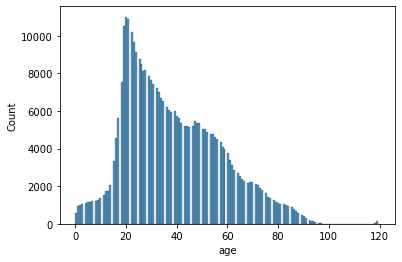

In [12]:
#Grouping people by age group
df['age'] = df['year']-df['dob']
sns.histplot(df['age'])
bins= [0,18,25,60,80, 140]
labels = ['0_18','18_25','26_60','60_80','80_over']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

### Transforming data types

In [29]:
#replacing lat long ',' by '.'
df['lat']= df['lat'].str.replace(',','.')
df['long']= df['long'].str.replace(',','.')
df['lat']=pd.to_numeric(df['lat'])
df['long']=pd.to_numeric(df['long'])

In [30]:
df_quality(df)

,dtypes,isna%,isna
pedestrian_loc,object,92.7,340305
pedestrian_action,object,92.6,340168
pedestrian_group,object,92.3,338892
reserved_path,object,90.6,332675
fixed_obstacle_hurt,object,84.1,308898
infra_type,object,84.1,308930
safety_feat_2,object,47.9,175949
width_road_only,object,36.0,132045
journey_reason,object,26.6,97715
mobile_obstacle_hurt,object,19.2,70438


In [31]:
df['injury_level'].value_counts()

OK        300996
not_ok     66205
Name: injury_level, dtype: int64

### Impute missing values

Let's check out the distribution for each

<AxesSubplot:>

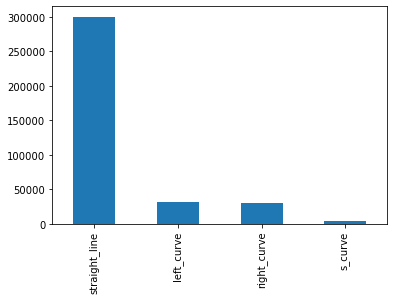

In [35]:
df['road_curve'].value_counts().plot(kind = 'bar')

We can use straight line with confidence

<AxesSubplot:>

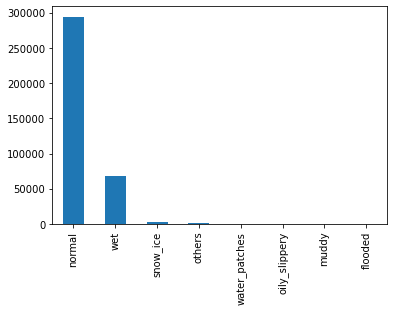

In [36]:
df['road_surface'].value_counts().plot(kind = 'bar')

we can use Normal with confidence

<AxesSubplot:>

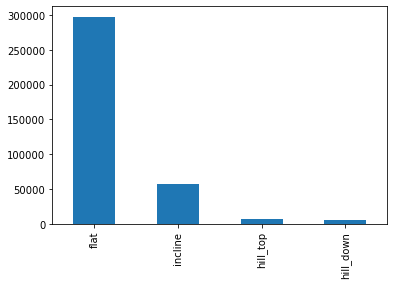

In [37]:
df['road_incline'].value_counts().plot(kind = 'bar')

We can use "flat" to impute

<AxesSubplot:>

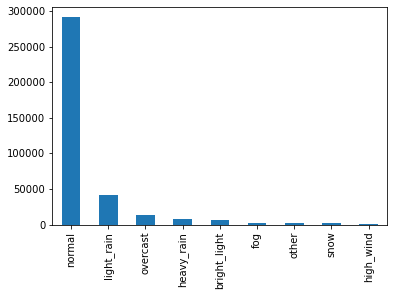

In [38]:
df['weather'].value_counts().plot(kind = 'bar')

Same thing for weather, we can use "Normal"

<AxesSubplot:>

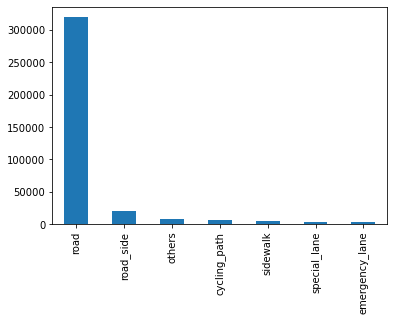

In [39]:
df['road_location_accident'].value_counts().plot(kind = 'bar')

We can impute using "road"

<AxesSubplot:>

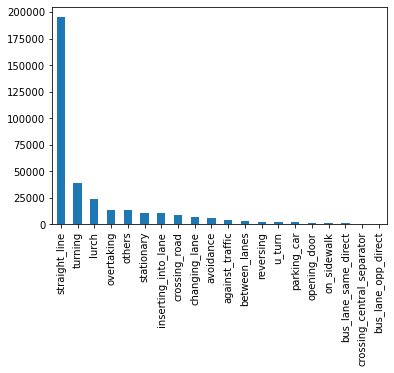

In [41]:
df['was_doing'].value_counts().plot(kind = 'bar')

and finally, straight line is the answer

<AxesSubplot:>

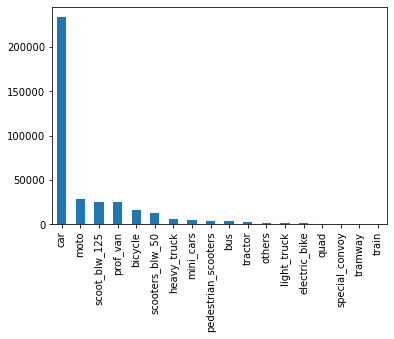

In [42]:
df['vehicule_type'].value_counts().plot(kind = 'bar')

We can use car here as well

In [43]:
#imputation 
df['road_curve'] =  df['road_curve'].fillna('straight_line')
df['road_surface'] =  df['road_surface'].fillna('normal')
df['road_incline'] =  df['road_incline'].fillna('flat')
df['weather'] =  df['weather'].fillna('normal')
df['road_location_accident'] =  df['road_location_accident'].fillna('road')
df['vehicule_type'] =  df['vehicule_type'].fillna('car') # car since 477 out of 500 missing are on road location = road 
df['was_doing'] =  df['was_doing'].fillna('straight_line')

In [44]:
df.shape

(367261, 57)

drop records for some of the missing values ( either critical or super low volume of records)

In [46]:
df.isna().sum().sort_values()

acc_num                        0
month                          0
road_surface                   0
year                           0
road_curve                     0
road_incline                   0
hhmm                           0
num_operating_lanes            0
department_fr                  0
city                           0
road_type                      0
in_out_city                    0
was_doing                      0
road_location_accident         0
lat                            0
weather                        0
long                           0
id_vehicule                    0
user_type                      0
vehicule_type                  0
event                          0
country                        0
hour                           0
day_of_week                    0
date                           0
YYYY-MM                        0
day                            0
crossing                       2
light_conditions               6
seat                          17
injury_lev

In [47]:
#We will drop the records for missing injury level, light condition and crossing  
df= df[~df['injury_level'].isna()] # 60 records
df = df[~df['light_conditions'].isna()] #17 records
df = df[~df['crossing'].isna()] #2 records
df.shape

(367193, 57)

In [49]:
df_quality(df)

,dtypes,isna%,isna
pedestrian_loc,object,92.7,340237
pedestrian_action,object,92.6,340101
pedestrian_group,object,92.3,338825
reserved_path,object,90.6,332615
fixed_obstacle_hurt,object,84.1,308839
infra_type,object,84.1,308873
safety_feat_2,object,47.9,175883
width_road_only,object,36.0,132045
journey_reason,object,26.6,97649
mobile_obstacle_hurt,object,19.2,70420


In [50]:
#clustering lat and longitude into 50 location clusters
# extract lat and long
X_lat = df['lat']
X_long = df['long']

# define all points
X_cluster = np.array((list(zip(X_lat, X_long))))

#kmeans gives us the cluster
clustering = KMeans(n_clusters=50, random_state=0)
clustering.fit(X_cluster)

# back to df_engineered
geo = pd.Series(clustering.labels_)
df['geo'] = geo

In [51]:
df.head()

,acc_num,id_vehicule,seat,user_type,injury_level,gender,dob,journey_reason,safety_feat_1,safety_feat_2,...,day_of_week,hour,YYYY-MM,event,speed_group,country,vehi_grp,age,age_group,geo
0,201900000001,138 306 524,driver,driver,OK,f,1993.0,leasure,safety_belt,no_equip,...,Saturday,1,2019-11,not_ph,4.0,France,4_wheels,26.0,26_60,11.0
1,201900000001,138 306 524,main_pass_front,passenger,OK,f,2002.0,NaN,safety_belt,no_equip,...,Saturday,1,2019-11,not_ph,4.0,France,4_wheels,17.0,0_18,11.0
2,201900000001,138 306 525,driver,driver,OK,m,1959.0,NaN,safety_belt,no_equip,...,Saturday,1,2019-11,not_ph,4.0,France,4_wheels,60.0,60_80,11.0
3,201900000002,138 306 523,driver,driver,OK,f,1994.0,NaN,safety_belt,no_equip,...,Saturday,2,2019-11,not_ph,4.0,France,4_wheels,25.0,26_60,11.0
4,201900000003,138 306 520,driver,driver,OK,m,1996.0,NaN,safety_belt,no_equip,...,Thursday,15,2019-11,not_ph,5.0,France,4_wheels,23.0,18_25,11.0


We are exporting this file to visualize the data in PowerBi

In [52]:
#exporting fiel ready for EDA  to AWS S3
bucket = aws_creds.bucket # already created on S3
csv_buffer = StringIO()
df.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'df_eda.csv').put(Body=csv_buffer.getvalue()) # exporting the dataframe to a csv file as 'df_english_sql.csv'

{'ResponseMetadata': {'RequestId': 'T96FG5FGJMN42R5Q',
  'HostId': 'rcuHlZ3CwLr6mQ6LqciKweeZwlqQVnnzYTPllJrP9DMO0IuR8PMFKpCBv4DQ0T4Aca2NTHkreKg=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'rcuHlZ3CwLr6mQ6LqciKweeZwlqQVnnzYTPllJrP9DMO0IuR8PMFKpCBv4DQ0T4Aca2NTHkreKg=',
   'x-amz-request-id': 'T96FG5FGJMN42R5Q',
   'date': 'Tue, 06 Dec 2022 11:45:55 GMT',
   'etag': '"9c8362487bb9b80612f34c90cff46666"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 1},
 'ETag': '"9c8362487bb9b80612f34c90cff46666"'}